# `Notebook de Model`

Notebook de Mickael MELKOWSKI

## `Config`

### `Import`

In [2]:
import pathlib
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# check for GPU support
torch.cuda.is_available()

True

In [ ]:
# config
# chemin relatif vers le dossier data
home = pathlib.Path("../")
path_to_data = pathlib.Path("../data")

data_folder_path = path_to_data / "raw" / "COVID-19_Radiography_Dataset"
output_path = path_to_data / "processed" / "covid_19_masked_tiny_500"
folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# model save path
# "/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/models"
model_save_path = home / "models"

../models


## `PyTorch`

### `Config`

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pathlib

# config
dataset_path = "/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny_500"



### `Normalization`

In [13]:
# Définir les transformations (optionnel, mais recommandé)
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Redimensionne les images
    transforms.ToTensor(),  # Convertit les images en tenseurs
])

# Charger les données à partir du dossier
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
#dataset_test = datasets.ImageFolder(root='Testing', transform=transform)

# mean and std for normalization
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

mean, std = get_mean_std(loader)

# Définir les transformations (optionnel, mais recommandé)
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Redimensionne les images
    transforms.ToTensor(),  # Convertit les images en tenseurs
    transforms.Normalize(mean=mean, std=std)  # normalize
])

# Re-Charger les données avec la nouvelle transformation
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

### `Splitting data`

In [14]:
# split dataset 80%, 20% --> [0.8, 0.2]
dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

In [15]:
# Create dataloader object
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

### `Baseline Model definition`

In [85]:
import torch.nn as nn
device = "cuda"
model = nn.Sequential(
   nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # output 16, 254, 254
   nn.MaxPool2d(kernel_size=2), # output 16, 127, 127
   nn.ReLU(),
    
   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 32, 125, 125
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=2), # output 32, 62, 62
    
   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # output  64, 60, 60
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=2), # output 64, 30, 30
    
   nn.Flatten(),
   nn.Linear(64 * 30 * 30, 64), # on précise ici la dim finale --> 64, 30, 30
   nn.ReLU(),
   nn.Linear(64, 4)

)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=57600, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=4, bias=True)
)

### `Summary`

In [58]:
from torchsummary import summary
summary(model, input_size=(3,256,256), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
              ReLU-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          18,496
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
          Flatten-10                [-1, 57600]               0
           Linear-11                   [-1, 64]       3,686,464
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 4]             260
Total params: 3,710,308
Trainable param

### `Loss function`

In [59]:
X_batch, y_batch = next(iter(dataloader_train))

# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

y_pred = model(X_batch.to(device))

criterion(y_pred, y_batch.to(device))

tensor(1.3776, device='cuda:0', grad_fn=<NllLossBackward0>)

### `Fitting`

In [60]:
from torch import optim
from tqdm.notebook import tqdm
epochs = 10

# Définition de l'optimizer
optimizer = optim.Adam(model.parameters(), 1e-2)


for epoch in range(epochs):
    # Dans ce mode certaines couches du modèle agissent différemment
    model.train()
    loss_total = 0
    # Barre de progression
    progress_bar = tqdm(
            dataloader_train, desc="Epoch {:1d}".format(epoch), leave=True, disable=False
        )
    
    for i, batch in enumerate(progress_bar):
        # Batch de données
        X_batch, y_batch = batch
        
        # Device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Gradient mis 0
        model.zero_grad()

        # Calcul de prédiction
        y_pred = model(X_batch.to(torch.float32))

        # Calcul de la fonction de perte
        loss =  criterion(y_pred, y_batch) #torch.mean(torch.abs(y_pred- y_batch.to(torch.float32)))#
        # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        #  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Descente de gradient : actualisation des paramètres
        optimizer.step()
        
        loss_total += loss.item()
        
        progress_bar.set_postfix(
            {
                "training_loss": "{:.3f}".format(loss_total/(i+1))}
        )

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

### `Evaluation`

In [61]:
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate(dataloader_val):
    # Passer le modèle en évaluation
    model.eval()
    # Calculer la loss totale
    loss_val_total = 0
    # Stocker les prédictions et les vraies valeurs.
    predictions, true_vals = [], []
    for batch in dataloader_val:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            # Prédiction du modèle pour un batch donné
            y_pred = model(X_batch.to(torch.float32))
        # Calcul de la fonction de perte pour l'utiliser comme une métrique
        loss = criterion(y_pred, y_batch)
        # Cummuler la fonction de perte de tous les lots de données.
        loss_val_total += loss.item()
        # Enregistrer les prédictions pour les utiliser plus tard
        predictions.extend(y_pred.detach().cpu().numpy())
        # Enregistrer les vraies valeurs pour les utiliser plus tard
        true_vals.extend(y_batch.cpu().numpy())

    # Loss du jeu de données val
    loss_val_avg = loss_val_total / len(dataloader_val)
    # Ensemble des prédictions du jeu de données
    predictions = np.array(predictions)
    # Id prediction
    predictions = np.argmax(predictions, axis=-1)
    # Ensemble des vraies valeurs du jeu de données
    true_vals = np.array(true_vals)
    return {"loss":loss_val_avg, "accuracy":accuracy_score(true_vals, predictions)}


metrics = evaluate(dataloader_test)

print(f"Loss: {metrics['loss']}")
print(f"Accuracy : {metrics['accuracy']}")

Loss: 1.3901405429840088
Accuracy : 0.24625


### `Confusion matrix`

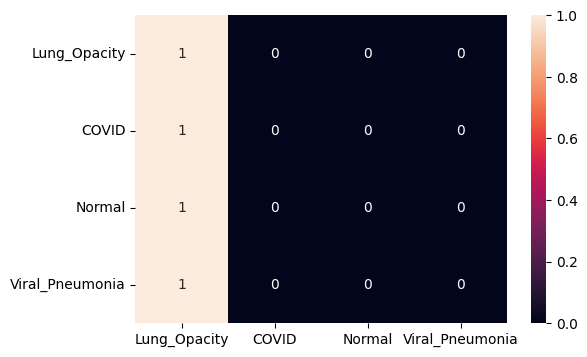

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

on_cuda = True # computed using cuda

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
    if on_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = folder_to_process

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True)


## `DenseNet-121 architecture`

Using tuto on kaggle: [covid-19-detection-pytorch-tutorial](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [17]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image


### `Model creation`

In [18]:
class_names = folder_to_process
device="cuda"

def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

/home/tylio/code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tylio/code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Number of param to train

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6957956


### `Training function`

In [21]:
dataloaders = {"train":dataloader_train, 
               "val":dataloader_test}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

metrics = {
    "acc":[],
    "val_acc":[],
    "loss":[],
    "val_loss":[],
}

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))

            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]

            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print(f'{phase} Loss: {epoch_loss:.4f} | {phase} Accuracy: {epoch_acc:.4f} | Kappa Score: {epoch_kappa:.4f}')
                metrics["acc"].append(float(epoch_acc))
                metrics["loss"].append(float(epoch_loss))
            else:
                print(f'{phase} Loss: {epoch_loss:.4f} | {phase} Accuracy: {epoch_acc:.4f}')
                metrics["val_acc"].append(float(epoch_acc))
                metrics["val_loss"].append(float(epoch_loss))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

### `Visual functions`

In [22]:
print(mean)
print(std)

tensor(1.4582e-07)
tensor(2.8320e-07)


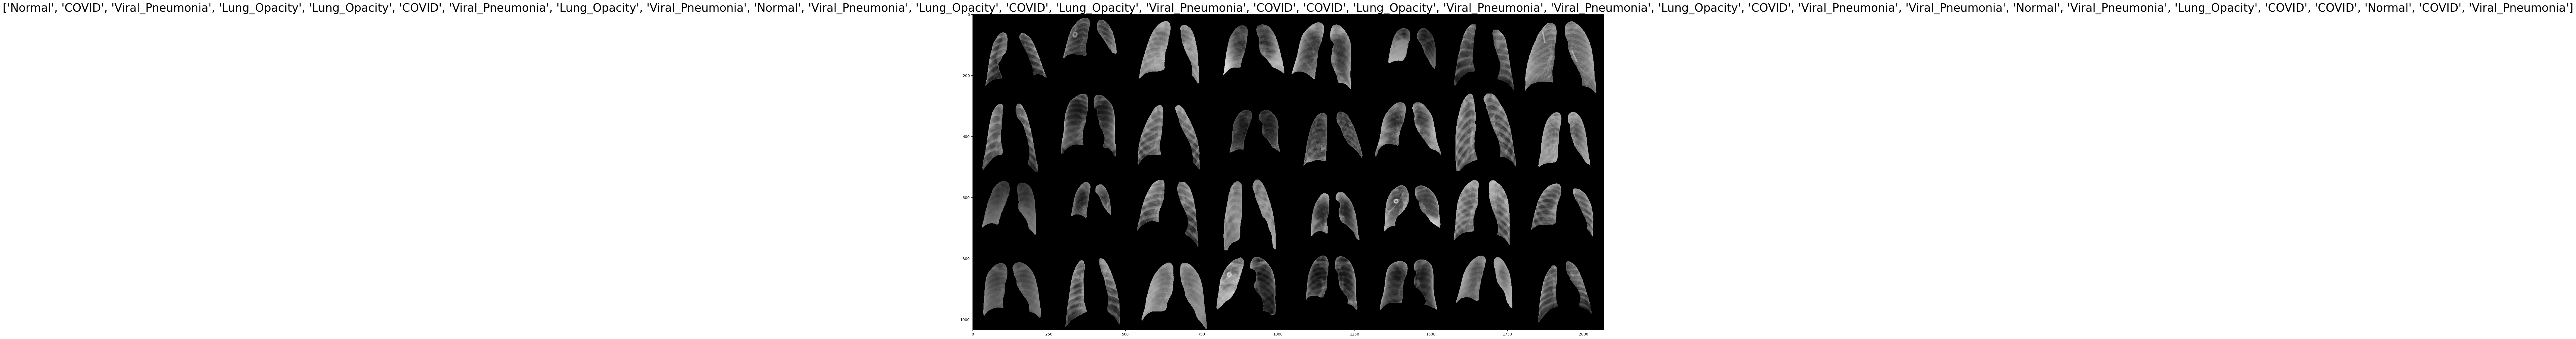

In [23]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [mean, mean, mean]
std_nums = [std, std, std]

def imshow(inp, size =(30,30), title=None, normalized=True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    if normalized:
        mean = mean_nums
        std = std_nums
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### `Training`

In [25]:
nb_epochs = 10
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, num_epochs=nb_epochs)

Epoch 1/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.6927 | train Accuracy: 0.7119


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6071 | val Accuracy: 0.7400 | Kappa Score: 0.6489
Val loss Decreased from inf to 0.6071 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5822 | train Accuracy: 0.7681


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6075 | val Accuracy: 0.7525 | Kappa Score: 0.6652

Epoch 3/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5910 | train Accuracy: 0.7594


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6076 | val Accuracy: 0.7500 | Kappa Score: 0.6621

Epoch 4/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5860 | train Accuracy: 0.7675


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6072 | val Accuracy: 0.7575 | Kappa Score: 0.6716

Epoch 5/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5863 | train Accuracy: 0.7694


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6070 | val Accuracy: 0.7550 | Kappa Score: 0.6683
Val loss Decreased from 0.6071 to 0.6070 
Saving Weights... 

Epoch 6/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5880 | train Accuracy: 0.7769


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6072 | val Accuracy: 0.7500 | Kappa Score: 0.6623

Epoch 7/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5824 | train Accuracy: 0.7631


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6072 | val Accuracy: 0.7525 | Kappa Score: 0.6653

Epoch 8/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5788 | train Accuracy: 0.7794


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6084 | val Accuracy: 0.7400 | Kappa Score: 0.6490

Epoch 9/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5897 | train Accuracy: 0.7631


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6104 | val Accuracy: 0.7350 | Kappa Score: 0.6425

Epoch 10/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5905 | train Accuracy: 0.7675


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.6106 | val Accuracy: 0.7450 | Kappa Score: 0.6549

Training complete in 1m 28s
Best val loss: 0.6070


### `Saving`

In [36]:
torch.save(model.state_dict(), model_save_path / "pytorch/dense121_normalized.pt")

### `Loading`

See: [PyTorch saving_loading_models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
model = CNN_Model(pretrained=True)
model.load_state_dict(torch.load(model_save_path / "pytorch/dense121_normalized.pt", weights_only=True))
model.eval()

### `Eval and visualisation`

In [ ]:
visualize_model(base_model)
plt.show()

### `Accuracy and loss`

In [28]:
print(metrics["acc"])

[0.74, 0.7525000000000001, 0.75, 0.7575000000000001, 0.755, 0.75, 0.7525000000000001, 0.74, 0.735, 0.745]


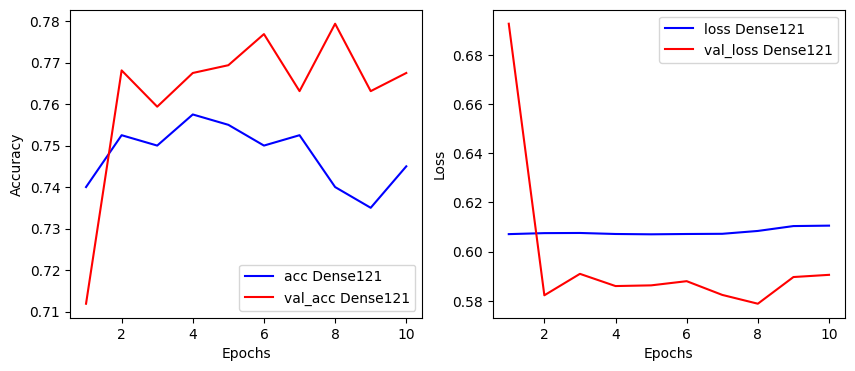

In [29]:
# use metrics dict from train function

nb_epochs = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# Courbe du score de test du réseau Dense 121
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["acc"], 
         label = 'acc Dense121',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["val_acc"],
         label = 'val_acc Dense121',
         color = 'red')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()

plt.subplot(1,2,2)
# Courbe du score de test du réseau Dense 121
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["loss"], 
         label = 'loss Dense121',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["val_loss"],
         label = 'val_loss Dense121',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### `Confusion Matrix`

Text(0.5, 1.0, 'DenseNet121 Confusion Matrix')

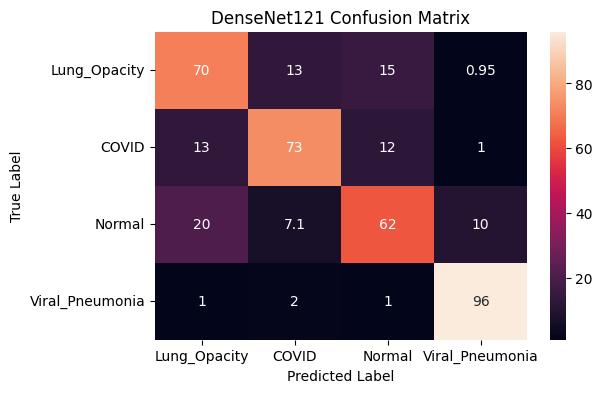

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

on_cuda = True # computed using cuda

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
    if on_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = folder_to_process

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(100*cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DenseNet121 Confusion Matrix')